# Train and deploy with FfDL and Seldon demo


##### A simple IBM OSS pipeline demonstrates how to train a model using Fabric for Deep Learning and then deploy it with Seldon.

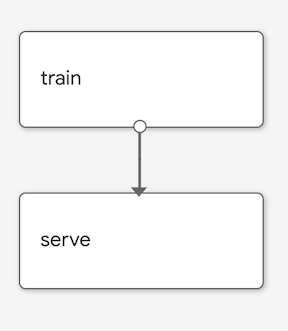

### Model for this pipeline

We will be training a PyTorch model that can classify the gender of a human face image. This PyTorch model is a simple convolutional neural network (CNN) with 3 convolutional layers and 2 fully connected layers using the [UTKFace](https://susanqq.github.io/UTKFace/) dataset. We will be training for 5 epochs for the purpose of this demo.

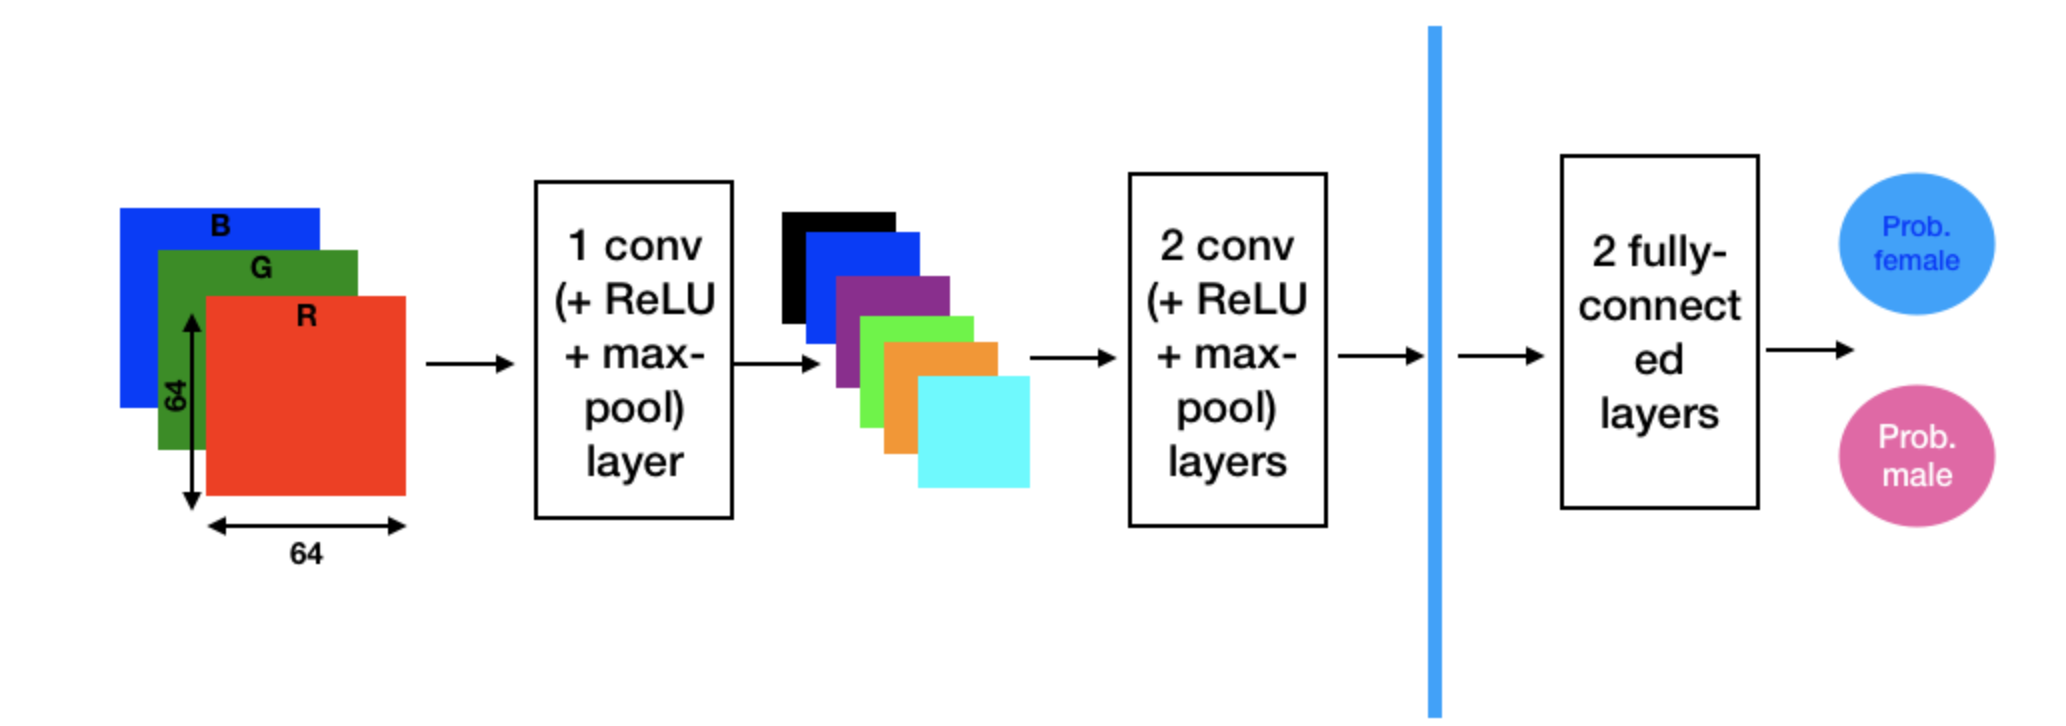
<br>

### Define the necessary environment variables and install the KubeFlow Pipeline SDK
We assume this notebook kernel has access to Python's site-packages and is in Python3.

**Please fill in the below environment variables with you own settings.**

- **KFP_PACKAGE**: The release of kubeflow pipeline library.

In [ ]:
KFP_PACKAGE = 'https://storage.googleapis.com/ml-pipeline/release/0.1.17/kfp.tar.gz'

In [ ]:
config_file_url = ''
github_token = ''

### Install the necessary python packages

Note: Please change pip to the package manager that's used for this Notebook Kernel.

In [ ]:
!pip install $KFP_PACKAGE --upgrade
!pip install ai_pipeline_params --upgrade

### Import the KubeFlow Pipeline library and define the client and experiment 

In [ ]:
import kfp
from kfp import compiler
import kfp
from kfp import components
from kfp import dsl
from kfp import notebook

# Run client with KUBEFLOW_PIPELINE_LINK if this notebook server
# is running on localhost without enterprise gateway.

# KUBEFLOW_PIPELINE_LINK = ''
# client = kfp.Client(KUBEFLOW_PIPELINE_LINK)

client = kfp.Client()


EXPERIMENT_NAME = 'FfDL-Seldon Experiments'

exp = client.create_experiment(name=EXPERIMENT_NAME)


### 2. Define pipeline tasks using the kfp library. 

In [ ]:
# define secret name that contains the credentials for this pipeline, and load components
secret_name = 'kfp-creds'
configuration_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/commons/config/component.yaml')
train_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/ffdl/train/component.yaml')
serve_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/ffdl/serve/component.yaml')

In [ ]:
import kfp.dsl as dsl
import ai_pipeline_params as params


# create pipeline
@dsl.pipeline(
  name='FfDL pipeline',
  description='A pipeline for machine learning workflow using Fabric for Deep Learning and Seldon.'
)
def ffdlPipeline(
    GITHUB_TOKEN=github_token,
    CONFIG_FILE_URL=config_file_url,
    model_def_file_path='gender-classification.zip',
    manifest_file_path='manifest.yml',
    model_deployment_name='gender-classifier',
    model_class_name='ThreeLayerCNN',
    model_class_file='gender_classification.py'
):
    """A pipeline for end to end machine learning workflow."""

    get_configuration = configuration_op(
                   token = GITHUB_TOKEN,
                   url = CONFIG_FILE_URL,
                   name = secret_name
    )

    train = train_op(
                   model_def_file_path,
                   manifest_file_path
    ).apply(params.use_ai_pipeline_params(secret_name))

    serve = serve_op(
                   train.output, 
                   model_deployment_name, 
                   model_class_name, 
                   model_class_file
    ).apply(params.use_ai_pipeline_params(secret_name))

In [ ]:
# Below are the default parameters for the above pipeline, 
# you can customize these parameters for each pipeline run.

parameters={'config-file-url': config_file_url,
            'github-token': github_token,
            'model-def-file-path': 'gender-classification.zip',
            'manifest-file-path': 'manifest.yml',
            'model-deployment-name': 'gender-classifier',
            'model-class-name': 'ThreeLayerCNN',
            'model-class-file': 'gender_classification.py'}


compiler.Compiler().compile(ffdlPipeline,  'ffdl-pipeline.tar.gz')

run = client.run_pipeline(exp.id, 'ffdl-seldon-pipeline', 'ffdl-pipeline.tar.gz', 
                          params=parameters)
import IPython
html = ('<p id="link"> </p> <script> document.getElementById("link").innerHTML = "Actual Run link <a href=//" + location.hostname + "%s/#/runs/details/%s target=_blank >here</a>"; </script>'
          % (client._get_url_prefix(), run.id))
IPython.display.HTML(html)